In [1]:
import pandas as pd
import numpy as np
from scipy import stats, special
from scipy.optimize import minimize 

import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Data
db = pd.read_csv('data/mon.csv')

# remove subjects with no lottery selections
badchoices = db[['sub','choice']].groupby('sub').sum()
badsubs = badchoices[badchoices['choice']<10].index.values
print("subs to remove for selecting only the ref", badsubs)

db = db[db['sub'].isin(badsubs) == False]

# add serial number for participants
db['subn'] = db['sub'].rank(method='dense').astype(int)-1
#db['subject'] = db['subn'].astype('category') 

# remove missing trials
db = db.dropna()
db['choice'] = db['choice'].astype('int')

#remove awarness check trials (value = 5)
#db = db[db['value']>5]

# sort dataframe based on subject, makes it easier to compare the output of the models.
db = db.sort_values('subn').reset_index(drop=True)

# get final number of subject and trials
n_subs = db['subn'].unique().shape[0]
sub_idx = db.subn.tolist()
print("Final sample includ {} subjects and {} valid trials".format(n_subs, len(sub_idx)))

subs to remove for selecting only the ref [11 14 16 40 50 65]
Final sample includ 46 subjects and 3820 valid trials


In [3]:
def MLE_riskamb(parameters):
    # extract parameters
    α, β, γ = parameters
    
    # caclulate proportion between SVs
    svLotto = (db_sub['value'].values ** α) * (1-(db_sub['risk'].values+(β * (db_sub['ambiguity'].values/2))))
    svRef = 5 ** α
    p = special.expit((svRef - svLotto) * γ) 
    
    # Calculate the negative log-likelihood for normal distribution
    neg_LL = -np.sum(stats.norm.logpdf(db_sub.choice, p))
    return neg_LL

def MLE_analysis():
    mle_model = minimize(MLE_riskamb, np.array([0.5,0.5,1]), method='L-BFGS-B', bounds=[(0,2),(-1.5,1.5),(-np.inf,np.inf)])
    x = mle_model.x
    return x

In [4]:
subs = db['sub'].unique()
mLL = pd.DataFrame()

for sub in subs:
    db_sub = db[db['sub']==sub]
    x = MLE_analysis()
    temp = {'sub': sub, 'alpha_mll' : x[0], 'beta_mll': x[1], 'gamma_mll': x[2]}
    mLL = mLL.append(temp,ignore_index=True)
# mLL.head()

In [5]:
with pm.Model() as RiskAmb:
    # Hyper Priors
    aMu = pm.Normal('aMu', 0.7 ,1)
    aSig = pm.Exponential('aSig', 1)
    bMu = pm.Normal('bMu', 0,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)


    α = pm.TruncatedNormal('α', aMu, aSig, lower = 0, upper = 2, shape = n_subs)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
    
    
      
    # Expected value of outcome
    svLotto = (db['value'].values ** α[sub_idx]) * (db['risk'].values - (β[sub_idx] * (db['ambiguity'].values/2)))
    svRef = 5 ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace = pm.sample(4000, return_inferencedata=True, target_accept=0.95)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, β, α, gSig, gMu, bSig, bMu, aSig, aMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 261 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'γ'}>,
        <AxesSubplot:title={'center':'γ'}>]], dtype=object)

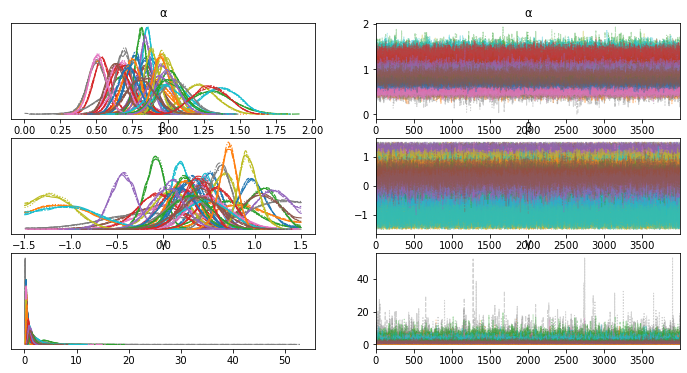

In [6]:
az.plot_trace(trace, var_names=['α','β','γ'])

In [7]:
with RiskAmb:
    ppc = pm.sample_posterior_predictive(trace)

<AxesSubplot:xlabel='choice / choice'>

/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


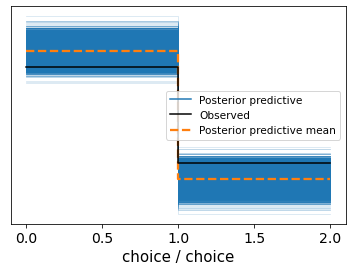

In [8]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=RiskAmb))

In [19]:
df = db[['sub','subn']].sort_values('subn').drop_duplicates().reset_index(drop=True)

age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='scans').iloc[:, [1,7,8]]
age.columns.values[0] = "sub"
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_')))

df = df.merge(age, left_on='sub', right_on='sub')

df.head(10)

,sub,subn,Age,Male
0,10,0,18.742466,1
1,13,1,48.684932,0
2,15,2,58.394521,0
3,18,3,83.169863,0
4,19,4,32.167123,1
5,20,5,56.517808,1
6,21,6,47.128767,0
7,22,7,54.000000,1
8,23,8,33.797260,1
9,24,9,27.690411,1


In [20]:
alpha = az.summary(trace, var_names=['α'])[['mean','sd']]
beta = az.summary(trace, var_names=['β'])[['mean','sd']]
gamma = az.summary(trace, var_names=['γ'])[['mean','sd']]

alpha = alpha.rename(columns={'mean': "alpha_pymc", 'sd': 'alpha_sd'}).reset_index(drop=True)
beta = beta.rename(columns={'mean': "beta_pymc", 'sd': 'beta_sd'}).reset_index(drop=True)
gamma = gamma.rename(columns={'mean': "gamma_pymc", 'sd': 'gamma_sd'}).reset_index(drop=True)


df = df.merge(alpha, left_index=True, right_index=True)
df = df.merge(beta, left_index=True, right_index=True)
df = df.merge(gamma, left_index=True, right_index=True)

df = df.merge(mLL, left_on='sub', right_on='sub')
df.head()

,sub,subn,Age,Male,alpha_pymc,alpha_sd,beta_pymc,beta_sd,gamma_pymc,gamma_sd,alpha_mll,beta_mll,gamma_mll
0,10,0,18.742466,1,0.889,0.064,0.490,0.136,0.573,0.164,1.045662,0.702969,-0.913217
1,13,1,48.684932,0,0.896,0.115,0.426,0.286,2.283,0.980,0.000000,-1.500000,1.635946
2,15,2,58.394521,0,0.685,0.094,0.734,0.272,1.061,0.374,0.480625,-1.500000,0.618762
3,18,3,83.169863,0,0.544,0.065,0.242,0.205,0.452,0.137,0.000000,1.500000,-1.275214
4,19,4,32.167123,1,0.840,0.077,0.396,0.177,0.774,0.229,0.000000,-1.500000,0.748017


In [21]:
ifat = pd.read_csv('data/Aging_021722.txt', sep='\t')
df = df.merge(ifat, left_on='sub', right_on='subject')

In [22]:
df.corr()

,sub,subn,Age,Male,alpha_pymc,alpha_sd,beta_pymc,beta_sd,gamma_pymc,gamma_sd,alpha_mll,beta_mll,gamma_mll,subject,alpha,beta,slope,r2
sub,1.000000,0.998388,0.126310,0.021025,0.194266,0.040105,-0.049367,-0.160489,-0.020373,-0.051928,0.038337,0.025443,0.008693,1.000000,0.103332,-0.049174,0.002262,0.097096
subn,0.998388,1.000000,0.114987,0.024822,0.187988,0.029909,-0.059745,-0.154828,-0.029647,-0.059648,0.038405,0.043942,-0.002063,0.998388,0.095476,-0.065344,-0.009664,0.106346
Age,0.126310,0.114987,1.000000,-0.382399,-0.300313,0.099839,0.131888,0.300564,0.136439,0.157140,-0.121287,-0.097301,-0.035180,0.126310,-0.262782,0.135074,-0.095216,-0.388614
Male,0.021025,0.024822,-0.382399,1.000000,0.252328,-0.117027,0.222166,-0.301722,-0.112800,-0.130557,0.005175,0.009534,-0.023826,0.021025,0.232539,0.206984,-0.222404,0.374912
alpha_pymc,0.194266,0.187988,-0.300313,0.252328,1.000000,0.620114,-0.107144,-0.182607,0.525081,0.475874,-0.069398,-0.364396,0.657106,0.194266,0.869759,-0.082677,0.224496,-0.033560
alpha_sd,0.040105,0.029909,0.099839,-0.117027,0.620114,1.000000,-0.025917,0.551184,0.882231,0.863510,-0.447388,-0.490229,0.710883,0.040105,0.681669,-0.041304,0.407563,-0.646393
beta_pymc,-0.049367,-0.059745,0.131888,0.222166,-0.107144,-0.025917,1.000000,-0.226667,-0.005078,-0.067177,0.039094,-0.278053,-0.057332,-0.049367,0.018700,0.918719,-0.115377,0.060956
beta_sd,-0.160489,-0.154828,0.300564,-0.301722,-0.182607,0.551184,-0.226667,1.000000,0.518840,0.577815,-0.407587,-0.153828,0.227820,-0.160489,-0.026671,-0.254668,0.344252,-0.685859
gamma_pymc,-0.020373,-0.029647,0.136439,-0.112800,0.525081,0.882231,-0.005078,0.518840,1.000000,0.986593,-0.353014,-0.466025,0.830442,-0.020373,0.733426,-0.010360,0.352630,-0.601603
gamma_sd,-0.051928,-0.059648,0.157140,-0.130557,0.475874,0.863510,-0.067177,0.577815,0.986593,1.000000,-0.313275,-0.410662,0.769020,-0.051928,0.675011,-0.071643,0.319258,-0.619936


In [13]:
prop = db.groupby(['sub','ambiguity','risk','value'], as_index=False)['choice'].mean()
prop.head()

,sub,ambiguity,risk,value,choice
0,10,0.0,0.25,5,0.00
1,10,0.0,0.25,8,0.00
2,10,0.0,0.25,12,0.00
3,10,0.0,0.25,25,0.75
4,10,0.0,0.50,5,0.00


In [14]:
subs = df['sub'].unique().tolist()
prop = prop[prop['sub'].isin(subs)].reset_index()

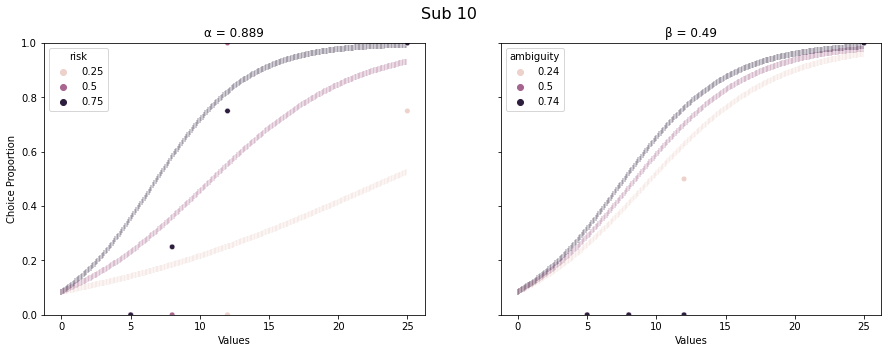

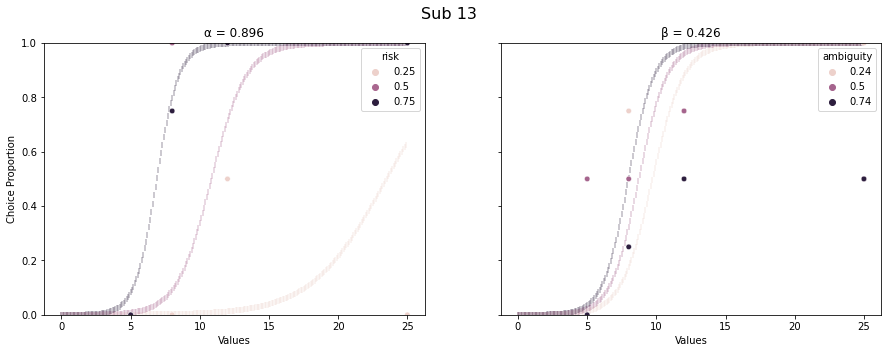

In [23]:
risks     = [0.25, 0.5, 0.75]
ambiguity = [0.24, 0.5, 0.74]

for sub in subs[:2]:
    
    figR=pd.DataFrame()
    figA=pd.DataFrame()
    
    f, ax = plt.subplots(1, 2, figsize=(15, 5),sharey=True)

    alpha  = float(df[df['sub']==sub]['alpha_pymc'])
    beta   = float(df[df['sub']==sub]['beta_pymc'])
    gamma  = float(df[df['sub']==sub]['gamma_pymc'])
    
    for value in np.arange(0, 25, 0.1):
        for risk in risks:
            svLotto = risk * value ** alpha
            svRef   = 5 ** alpha
            p = special.expit((svLotto - svRef) * gamma)
            temp = pd.DataFrame({'x': value, 'y': p,'risk':risk}, index=[0])
            figR = figR.append(temp)
        
        for amb in ambiguity:
            svLotto = (0.5 + beta * amb/2) * value ** alpha
            svRef   = 5 ** alpha
            p = special.expit((svLotto - svRef) * gamma)
            temp = pd.DataFrame({'x': value, 'y': p,'ambiguity':amb}, index=[0])
            figA = figA.append(temp)
    
    f.suptitle('Sub {}'.format(sub), fontsize=16)
    sns.scatterplot(x='x', y='y', data=figR, hue='risk', ax=ax[0], legend = False, marker="|")  
    sns.scatterplot(x='x', y='y', data=figA, hue='ambiguity', ax=ax[1], legend = False, marker="|") 
    
    fig = prop[prop['sub']==sub]
    figR = fig[fig['ambiguity']==0]
    figA = fig[fig['ambiguity'] > 0]
    
    sns.scatterplot(x='value', y='choice', data=figR, hue='risk', ax=ax[0], s=30)
    sns.scatterplot(x='value', y='choice', data=figA, hue='ambiguity', ax=ax[1], s=30)
    
    ax[0].set(xlabel="Values", ylabel="Choice Proportion", title="α = {}".format(alpha), ylim=(0,1))
    ax[1].set(xlabel="Values", title="β = {}".format(beta))
    plt.show()

In [24]:
pp=[]
pll = []    

for i in range(prop.shape[0]):
    sub = prop['sub'][i]
    alpha = float(df[df['sub']==sub]['alpha_pymc'])
    beta  = float(df[df['sub']==sub]['beta_pymc'])
    svLotto = (prop.risk[i] + beta * prop.ambiguity[i]/2) * prop.value[i] ** alpha
    svRef   = 5 ** alpha
    p = special.expit((svLotto - svRef))
    pp.append(p)
    
    alpha = float(df[df['sub']==sub]['alpha_mll'])
    beta  = float(df[df['sub']==sub]['beta_mll'])
    svLotto = (prop.risk[i] + beta * prop.ambiguity[i]/2) * prop.value[i] ** alpha
    svRef   = 5 ** alpha
    p = special.expit((svLotto - svRef))
    pll.append(p)
                      
prop['pymc'] = pp
prop['mll'] = pll
prop.head(10)

,index,sub,ambiguity,risk,value,choice,pymc,mll
0,0,10,0.0,0.25,5,0.00,0.041626,0.017362
1,1,10,0.0,0.25,8,0.00,0.069510,0.039846
2,2,10,0.0,0.25,12,0.00,0.129525,0.117033
3,3,10,0.0,0.25,25,0.75,0.547428,0.865096
4,4,10,0.0,0.50,5,0.00,0.109975,0.063528
5,5,10,0.0,0.50,8,0.00,0.267672,0.272323
6,6,10,0.0,0.50,12,1.00,0.591863,0.792429
7,7,10,0.0,0.50,25,1.00,0.989673,0.999888
8,8,10,0.0,0.75,5,0.00,0.260090,0.206636
9,9,10,0.0,0.75,8,0.25,0.641367,0.771419


In [25]:
r2pymc = pd.DataFrame()
for s in subs:
    
    pro = prop[prop['sub']==s]
    r2 = np.corrcoef(pro.choice, pro.pymc)[0][1]
    r2mll = np.corrcoef(pro.choice, pro.mll)[0][1]
    temp = pd.DataFrame({'sub': s, 
                        'r2pymc': r2,
                        'r2mll': r2mll}, index=[0])
    r2pymc = r2pymc.append(temp)
    
df = df.merge(r2pymc, left_on='sub', right_on='sub')
df.head()

,sub,subn,Age,Male,alpha_pymc,alpha_sd,beta_pymc,beta_sd,gamma_pymc,gamma_sd,alpha_mll,beta_mll,gamma_mll,subject,alpha,beta,slope,r2,r2pymc,r2mll
0,10,0,18.742466,1,0.889,0.064,0.490,0.136,0.573,0.164,1.045662,0.702969,-0.913217,10,0.889722,0.520942,-1.955494,0.666511,0.769147,0.714589
1,13,1,48.684932,0,0.896,0.115,0.426,0.286,2.283,0.980,0.000000,-1.500000,1.635946,13,1.028045,0.670166,-0.338559,0.198659,0.649345,0.351954
2,15,2,58.394521,0,0.685,0.094,0.734,0.272,1.061,0.374,0.480625,-1.500000,0.618762,15,0.674981,0.720106,-1.095697,0.293179,0.320635,0.612059
3,18,3,83.169863,0,0.544,0.065,0.242,0.205,0.452,0.137,0.000000,1.500000,-1.275214,18,0.499448,0.106756,-2.961613,0.480662,0.758523,0.067638
4,19,4,32.167123,1,0.840,0.077,0.396,0.177,0.774,0.229,0.000000,-1.500000,0.748017,19,0.841002,0.425222,-1.415259,0.509504,0.828301,0.362902


In [26]:
np.mean(df.r2)

0.5706479767441862

In [27]:
np.mean(df.r2pymc)

0.6815302601766299

In [28]:
np.mean(df.r2mll)

0.4571995183479011

In [53]:
freesurfer = pd.read_csv('data/aprac.txt', sep='\t')
freesurfer['sub'] = [s.replace('sub-' , '') for s in sup['rh.aparc.a2009s.thickness']]

sup = freesurfer[['sub','rh_G_parietal_sup_thickness','eTIV']]
sup.head()

,sub,rh_G_parietal_sup_thickness,eTIV
0,10,2.259,1.722888e+06
1,11,2.263,1.358734e+06
2,13,1.995,1.275879e+06
3,14,2.288,1.574182e+06
4,15,2.099,1.637665e+06


In [57]:
import pingouin as pg

In [56]:
sup['sub'] = sup['sub'].astype(int)
df2 = df.merge(sup, left_on='sub', right_on='sub')
df2.head()

/tmp/ipykernel_253441/3656633057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sup['sub'] = sup['sub'].astype(int)


,sub,subn,Age,Male,alpha_pymc,alpha_sd,beta_pymc,beta_sd,gamma_pymc,gamma_sd,...,gamma_mll,subject,alpha,beta,slope,r2,r2pymc,r2mll,rh_G_parietal_sup_thickness,eTIV
0,10,0,18.742466,1,0.889,0.064,0.490,0.136,0.573,0.164,...,-0.913217,10,0.889722,0.520942,-1.955494,0.666511,0.769147,0.714589,2.259,1.722888e+06
1,13,1,48.684932,0,0.896,0.115,0.426,0.286,2.283,0.980,...,1.635946,13,1.028045,0.670166,-0.338559,0.198659,0.649345,0.351954,1.995,1.275879e+06
2,15,2,58.394521,0,0.685,0.094,0.734,0.272,1.061,0.374,...,0.618762,15,0.674981,0.720106,-1.095697,0.293179,0.320635,0.612059,2.099,1.637665e+06
3,18,3,83.169863,0,0.544,0.065,0.242,0.205,0.452,0.137,...,-1.275214,18,0.499448,0.106756,-2.961613,0.480662,0.758523,0.067638,2.034,1.438339e+06
4,19,4,32.167123,1,0.840,0.077,0.396,0.177,0.774,0.229,...,0.748017,19,0.841002,0.425222,-1.415259,0.509504,0.828301,0.362902,2.201,1.820525e+06


In [66]:
pg.partial_corr(data=df2,x='alpha_pymc',y='rh_G_parietal_sup_thickness',covar=['eTIV','Age'])
#pg.corr(df2.Age, df2.eTIV)

,n,r,CI95%,p-val
pearson,31,0.124666,"[-0.25, 0.47]",0.519358
